In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np
import math
import json
import cv2

import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

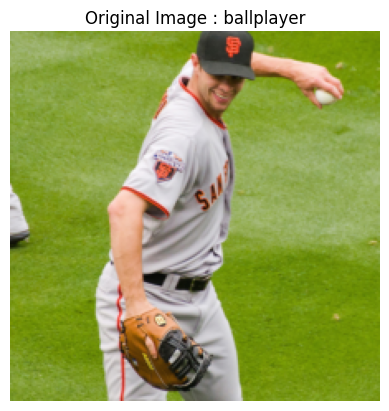

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
model.eval()

mu = torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
sigma = torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

input_image = "./data/person.jpg"

image = Image.open(input_image).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

image_tensor = preprocess(image).unsqueeze(0).to(device) # (N,C,H,W) - N = batchsize 추가

def normalize(image, mu, sigma):
    return (image - mu) / sigma

normalized_image = normalize(image_tensor, mu, sigma)

output = model(normalized_image)

_, predict = torch.max(output, 1)

# print(predict)

labels = idx2label[predict.item()]

original_image = image_tensor.squeeze(0).permute(1,2,0).detach().cpu().numpy() # (C,H,W) -> (H,W,C)
original_image = np.clip(original_image, a_min=0,a_max=1)

plt.imshow(original_image)
plt.axis("off")
plt.title(f"Original Image : {labels}")
plt.show()

In [3]:
def predict(x):
    out = (x - mu) / sigma
    return model(out)

def to_pytorch(tensor_image):
    return torch.from_numpy(tensor_image).permute(2, 0, 1)

class UnTargeted:
    def __init__(self, model, true, unormalize=False, to_pytorch=False):
        self.model = model
        self.true = true
        self.unormalize = unormalize
        self.to_pytorch = to_pytorch

    def get_label(self, img):
        if self.unormalize:
            img_ = img * 255.
        else:
            img_ = img

        if self.to_pytorch:
            img_ = to_pytorch(img_)
            img_ = img_[None, :].to(device)
            preds = predict(img_).flatten()
            y = int(torch.argmax(preds))
        else:
            preds = predict(torch.from_numpy(np.expand_dims(img_, axis=0)).to(device)).flatten()
            y = int(torch.argmax(preds))

        return y

    def __call__(self, img):
        if self.unormalize:
            img_ = img * 255.
        else:
            img_ = img

        if self.to_pytorch:
            img_ = to_pytorch(img_)
            img_ = img_[None, :].to(device)
            preds = predict(img_).flatten()
            y = int(torch.argmax(preds))
            preds = preds.tolist()
        else:
            preds = predict(torch.from_numpy(np.expand_dims(img_, axis=0)).to(device)).flatten()
            y = int(np.argmax(preds))

        is_adversarial = True if y != self.true else False

        f_true = math.log(math.exp(preds[self.true]) + 1e-30)
        preds[self.true] = -math.inf

        f_other = math.log(math.exp(max(preds)) + 1e-30)
        return [is_adversarial, float(f_true - f_other)]

def l2(adv_patch, orig_patch):
    assert adv_patch.shape == orig_patch.shape
    return np.sum((adv_patch - orig_patch) ** 2)

def sh_selection(n_queries, it):
    """ schedule to decrease the parameter p """
    t = max((float(n_queries - it) / n_queries - .0) ** 1., 0) * .75
    return t

def update_location(loc_new, h_i, h, s):
    loc_new += np.random.randint(low=-h_i, high=h_i + 1, size=(2,))
    loc_new = np.clip(loc_new, 0, h - s)
    return loc_new

def render(x, w):
    phenotype = np.ones((w, w, 3))
    radius_avg = (phenotype.shape[0] + phenotype.shape[1]) / 2 / 6
    for row in x:
        overlay = phenotype.copy()
        cv2.circle(
            overlay,
            center=(int(row[1] * w), int(row[0] * w)),
            radius=int(row[2] * radius_avg),
            color=(int(row[3] * 255), int(row[4] * 255), int(row[5] * 255)),
            thickness=-1,
        )
        alpha = row[6]
        phenotype = cv2.addWeighted(overlay, alpha, phenotype, 1 - alpha, 0)
    return phenotype/255.

def mutate(soln, mut):
    new_specie = soln.copy()
    genes = soln.shape[0]
    length = soln.shape[1]
    y = np.random.randint(0, genes)
    change = np.random.randint(0, length + 1)

    if change >= length + 1:
        change -= 1
        i, j = y, np.random.randint(0, genes)
        i, j, s = (i, j, -1) if i < j else (j, i, 1)
        new_specie[i: j + 1] = np.roll(new_specie[i: j + 1], shift=s, axis=0)
        y = j

    selection = np.random.choice(length, size=change, replace=False)

    if np.random.rand() < mut:
        new_specie[y, selection] = np.random.rand(len(selection))
    else:
        new_specie[y, selection] += (np.random.rand(len(selection)) - 0.5) / 3
        new_specie[y, selection] = np.clip(new_specie[y, selection], 0, 1)

    return new_specie

class Attack:
    def __init__(self, params):
        self.params = params
        self.process = []

    def completion_procedure(self, adversarial, x_adv, queries, loc, patch, loss_function):
        data = {
            "orig": self.params["x"],
            "adversary": x_adv,
            "adversarial": adversarial,
            "queries": queries,
            "loc": loc,
            "patch": patch,
            "patch_width": int(math.ceil(self.params["eps"] ** .5)),
            "final_prediction": loss_function.get_label(x_adv),
            "process": self.process
        }
        np.save(self.params["save_directory"], data, allow_pickle=True)
        return x_adv

    def optimise(self, loss_function):
        x = self.params["x"]
        c, h, w = self.params["c"], self.params["h"], self.params["w"]
        eps = self.params["eps"]
        s = int(math.ceil(eps ** .5))

        patch_geno = np.random.rand(self.params["N"], 7)
        patch = render(patch_geno, s)
        loc = np.random.randint(h - s, size=2)
        update_loc_period = self.params["update_loc_period"]

        x_adv = x.copy()
        x_adv[loc[0]: loc[0] + s, loc[1]: loc[1] + s, :] = patch
        x_adv = np.clip(x_adv, 0., 1.)
        adversarial, loss = loss_function(x_adv)
        l2_curr = l2(adv_patch=patch, orig_patch=x[loc[0]: loc[0] + s, loc[1]: loc[1] + s, :].copy())

        patch_counter = 0
        n_queries = self.params["n_queries"]
        for it in tqdm(range(1, n_queries)):
            patch_counter += 1
            if patch_counter < update_loc_period:
                patch_new_geno = mutate(patch_geno, self.params["mut"])
                patch_new = render(patch_new_geno, s)
                x_adv_new = x.copy()
                x_adv_new[loc[0]: loc[0] + s, loc[1]: loc[1] + s, :] = patch_new
                x_adv_new = np.clip(x_adv_new, 0., 1.)
                adversarial_new, loss_new = loss_function(x_adv_new)

                orig_patch = x[loc[0]: loc[0] + s, loc[1]: loc[1] + s, :].copy()
                l2_new = l2(adv_patch=patch_new, orig_patch=orig_patch)

                if adversarial == True and adversarial_new == True:
                    if l2_new < l2_curr:
                        loss = loss_new
                        adversarial = adversarial_new
                        patch = patch_new
                        patch_geno = patch_new_geno
                        x_adv = x_adv_new
                        l2_curr = l2_new
                else:
                    if loss_new < loss: # minimization
                        loss = loss_new
                        adversarial = adversarial_new
                        patch = patch_new
                        patch_geno = patch_new_geno
                        x_adv = x_adv_new
                        l2_curr = l2_new
            else:
                patch_counter = 0
                sh_i = int(max(sh_selection(n_queries, it) * h, 0))
                loc_new = loc.copy()
                loc_new = update_location(loc_new, sh_i, h, s)
                x_adv_new = x.copy()
                x_adv_new[loc_new[0]: loc_new[0] + s, loc_new[1]: loc_new[1] + s, :] = patch
                x_adv_new = np.clip(x_adv_new, 0., 1.)
                adversarial_new, loss_new = loss_function(x_adv_new)

                orig_patch_new = x[loc_new[0]: loc_new[0] + s, loc_new[1]: loc_new[1] + s, :].copy()
                l2_new = l2(adv_patch=patch, orig_patch=orig_patch_new)

                if adversarial == True and adversarial_new == True:
                    if l2_new < l2_curr:
                        loss = loss_new
                        adversarial = adversarial_new
                        loc = loc_new
                        x_adv = x_adv_new
                        l2_curr = l2_new
                else:
                    diff = loss_new - loss
                    curr_temp = self.params["temp"] / (it +1)
                    metropolis = math.exp(-diff/curr_temp)

                    if loss_new < loss or np.random.rand() < metropolis:  # minimization
                        loss = loss_new
                        adversarial = adversarial_new
                        loc = loc_new
                        x_adv = x_adv_new
                        l2_curr = l2_new
            self.process.append([loc, patch_geno])

        return self.completion_procedure(adversarial, x_adv, it, loc, patch, loss_function)

In [6]:
image_tensor = preprocess(image).to(device)

loss = UnTargeted(model, true=981, to_pytorch=True)
x = image_tensor.permute(1, 2, 0).cpu().detach().numpy()

params = {
    "x": x,
    "eps": 40**2,
    "n_queries": 1000,
    "save_directory": "./output/adve.npy",
    "c": x.shape[2],
    "h": x.shape[0],
    "w": x.shape[1],
    "N": 100,
    "update_loc_period": 4,
    "mut": 0.3,
    "temp": 300
}

attack = Attack(params)
adversarial_image = attack.optimise(loss)

 52%|█████▏    | 522/999 [00:40<00:36, 13.05it/s]

ballplayer


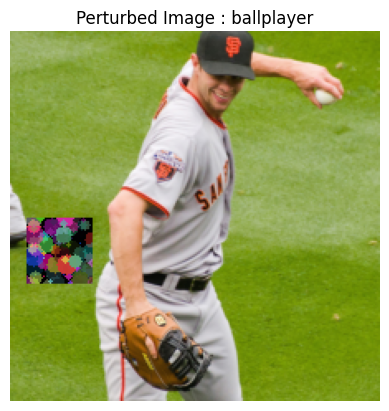

In [5]:
# 결과 출력
adversarial_image = torch.from_numpy(adversarial_image).permute(2, 0, 1).unsqueeze(0).to(device)
adversarial_output = model(adversarial_image)
_, adversarial_predict = torch.max(adversarial_output, 1)
adversarial_labels = idx2label[adversarial_predict.item()]

print(adversarial_labels)

perturbed_image = adversarial_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
perturbed_image = np.clip(perturbed_image, 0, 1)

plt.imshow(perturbed_image)
plt.axis("off")
plt.title(f"Perturbed Image : {adversarial_labels}")
plt.show()